# IMAGE RECONSTRUCTION VIA PCA, PPCA AND VARIATIONAL AUTOENCODER

## LOADING THE DATASET

In [1]:
from keras.datasets import mnist
import numpy as np

(trainImages, _), (testImages, _) = mnist.load_data()

trainImages, testImages = trainImages / 255.0, testImages / 255.0

#print("Training dimensions:", trainImages.shape)
#print("Test dimensions:", testImages.shape)

flattenedTrainImages = trainImages.reshape((trainImages.shape[0], -1))
flattenedTestImages = testImages.reshape((testImages.shape[0], -1))

print("Flattened training dimensions:", flattenedTrainImages.shape)
print("Flattened test dimensions:", flattenedTestImages.shape)

np.random.seed(42)      #To ensure that same images are used across pca and ppca. Change seed value for different images
selectedImages = np.random.choice(len(testImages), size = 5, replace=False)

Flattened training dimensions: (60000, 784)
Flattened test dimensions: (10000, 784)


## PCA IMPLEMENTATION

MSE for latent dimension 2 is: 0.05566949193442309


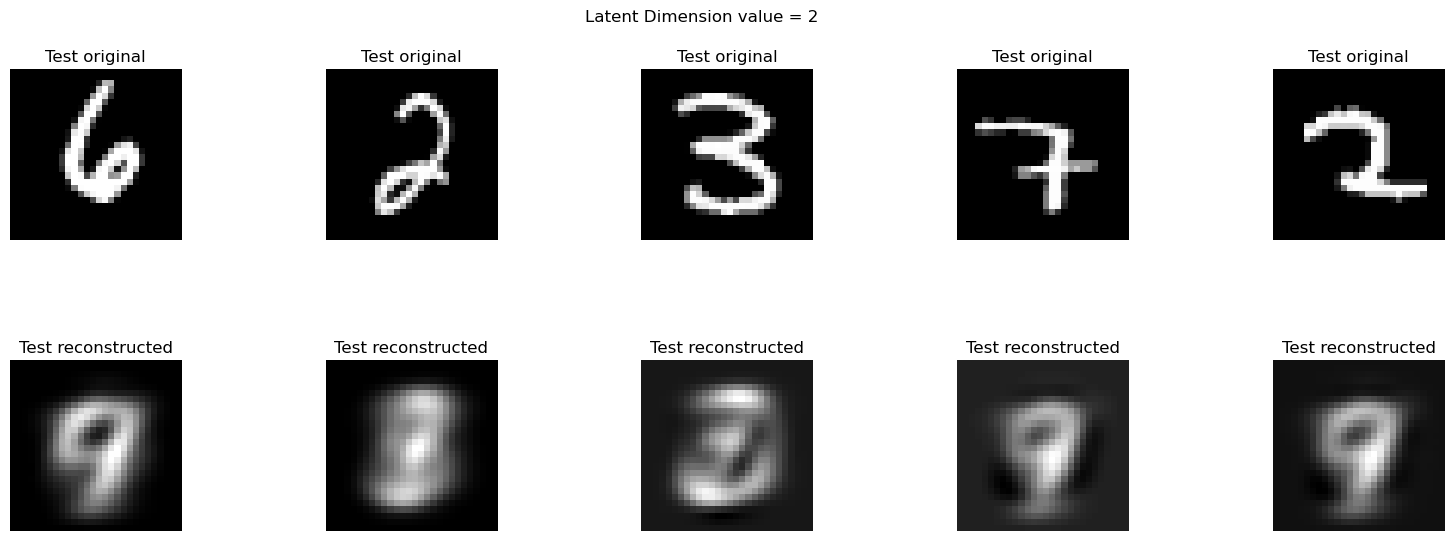

MSE for latent dimension 4 is: 0.04790346506558458


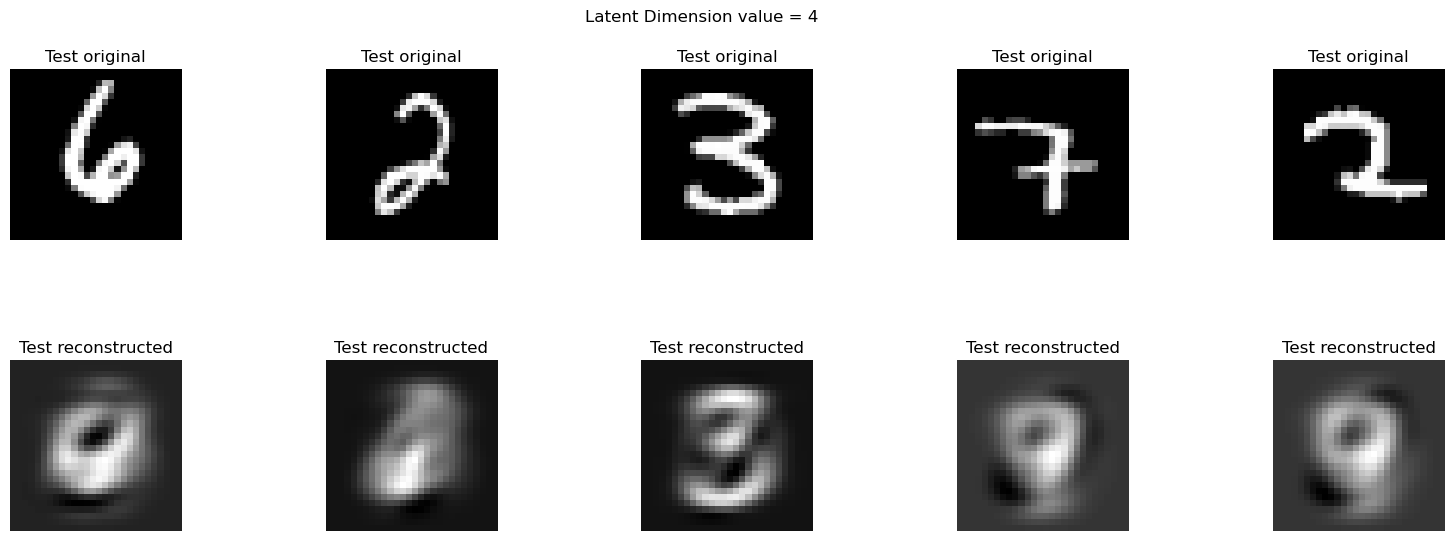

MSE for latent dimension 8 is: 0.03744093391903095


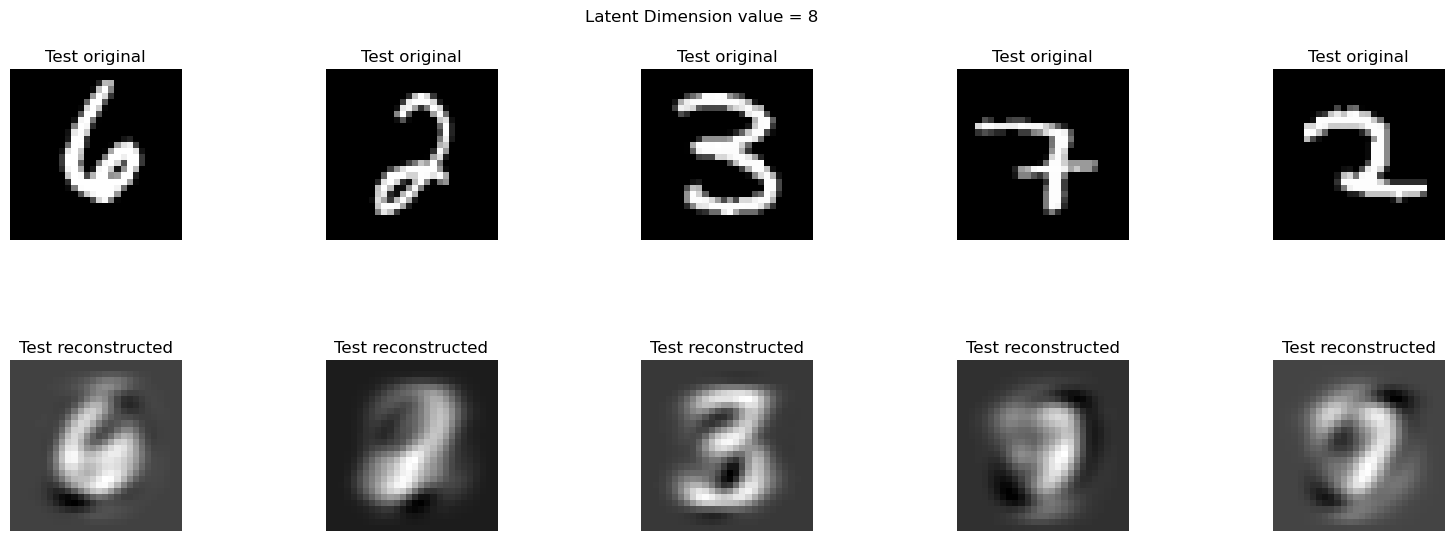

MSE for latent dimension 16 is: 0.02686019078827122


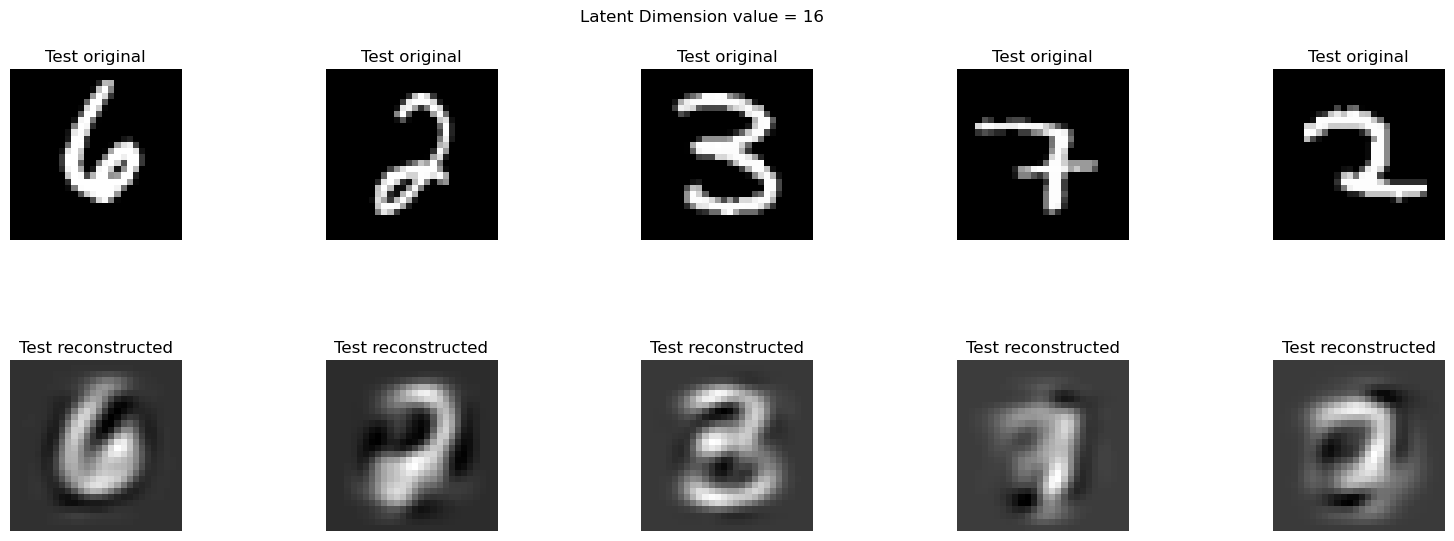

MSE for latent dimension 32 is: 0.016829987691859557


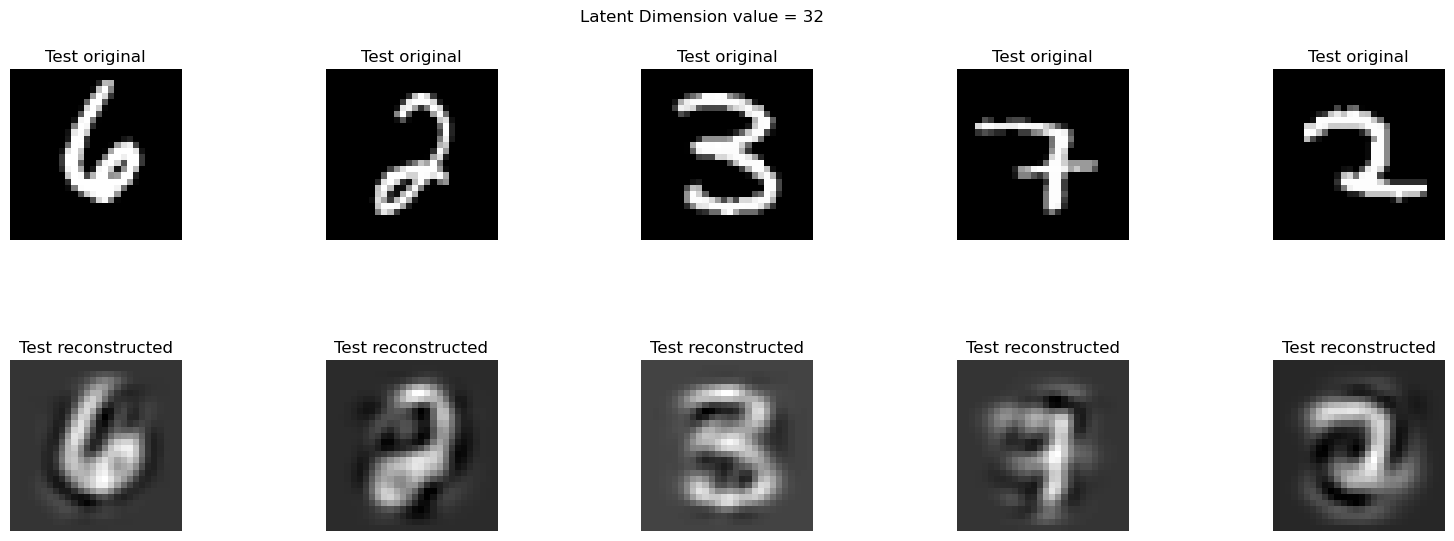

MSE for latent dimension 64 is: 0.009047770446754689


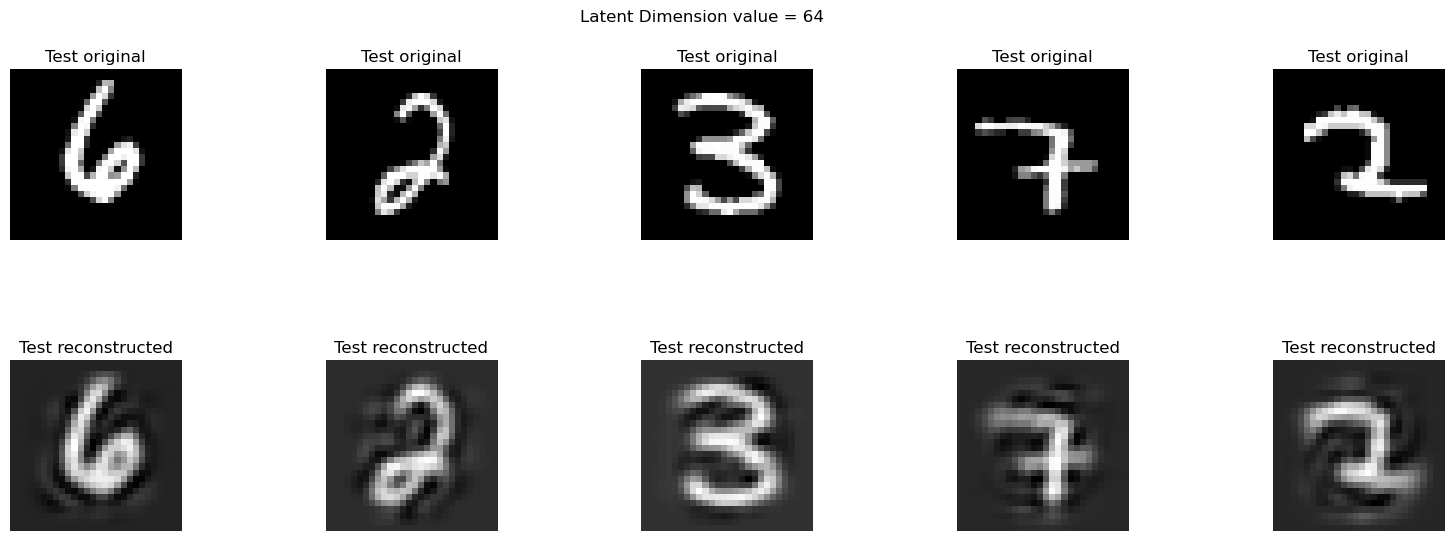

In [2]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

latentDimensions = [2, 4, 8, 16, 32, 64] 

def pcaFn(latentDimensionValue, flattenedTestImages):
    pca = PCA(n_components=latentDimensionValue)
    pca.fit(flattenedTrainImages)

    transformedImages = pca.inverse_transform(pca.transform(flattenedTestImages))
    transformedImages = transformedImages.reshape((-1, 28 * 28))    #Converting into 2d array

    return transformedImages

def pcaMSE(originalImages, reconstructedImages):
    return np.mean((originalImages - reconstructedImages)**2)

mse_values_list = []

for latentDimensionValue in latentDimensions:

    reconstructedImages = pcaFn(latentDimensionValue, flattenedTestImages)
    mseVal = pcaMSE(flattenedTestImages,reconstructedImages)
    mse_values_list.append(mseVal)
    
    print("MSE for latent dimension {} is: {}".format(latentDimensionValue,mseVal))

    plt.figure(figsize=(20,6))
    plt.suptitle(f"Latent Dimension value = {latentDimensionValue}")
 
    for i, idx in enumerate(selectedImages):
        plt.subplot(2, 5, i + 1)
        plt.imshow(testImages[idx], cmap='gray')
        plt.title(f"Test original")
        plt.axis('off') #Removes x and y axis labels

        plt.subplot(2, 5, i + 6)
        plt.imshow(reconstructedImages[idx].reshape(28,28), cmap='gray')    #reshaping the 1d array back to 2d for accessing
        plt.title(f"Test reconstructed")
        plt.axis('off')

    plt.subplots_adjust(hspace=0.7, wspace=0.1)
    plt.show()
    
mse_values_array = np.array(mse_values_list)


## PROBABILISTIC PCA IMPLEMENTATION

MSE val for latent dimension 2 is 0.06742457947489407


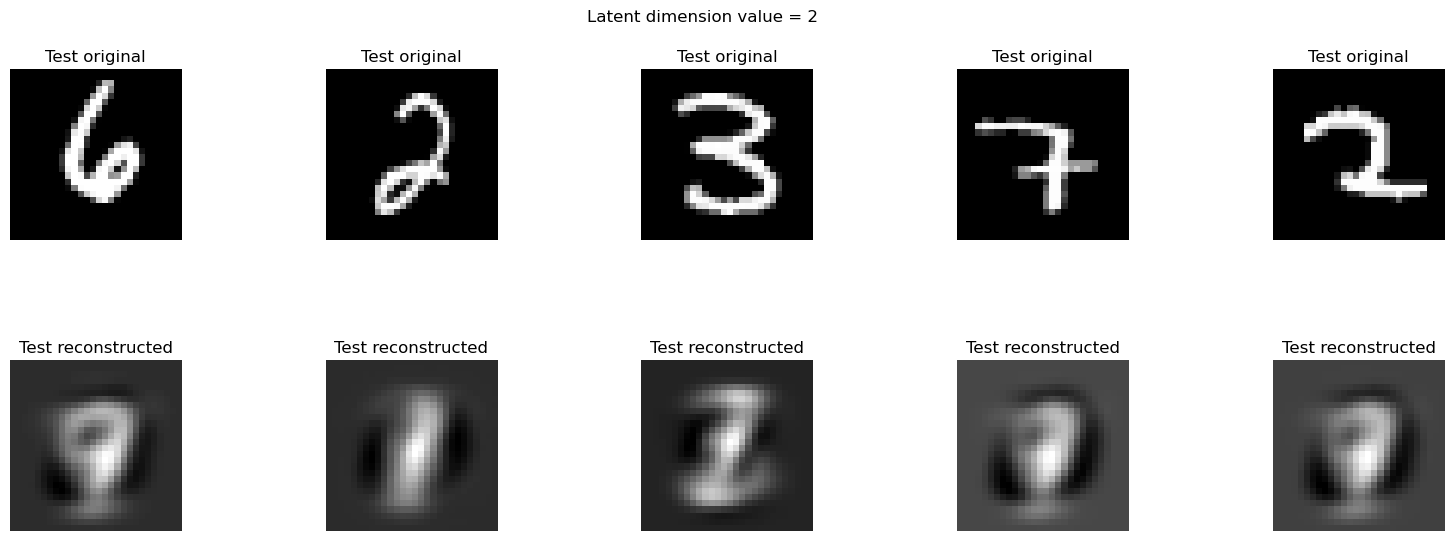

MSE val for latent dimension 4 is 0.06468975344922344


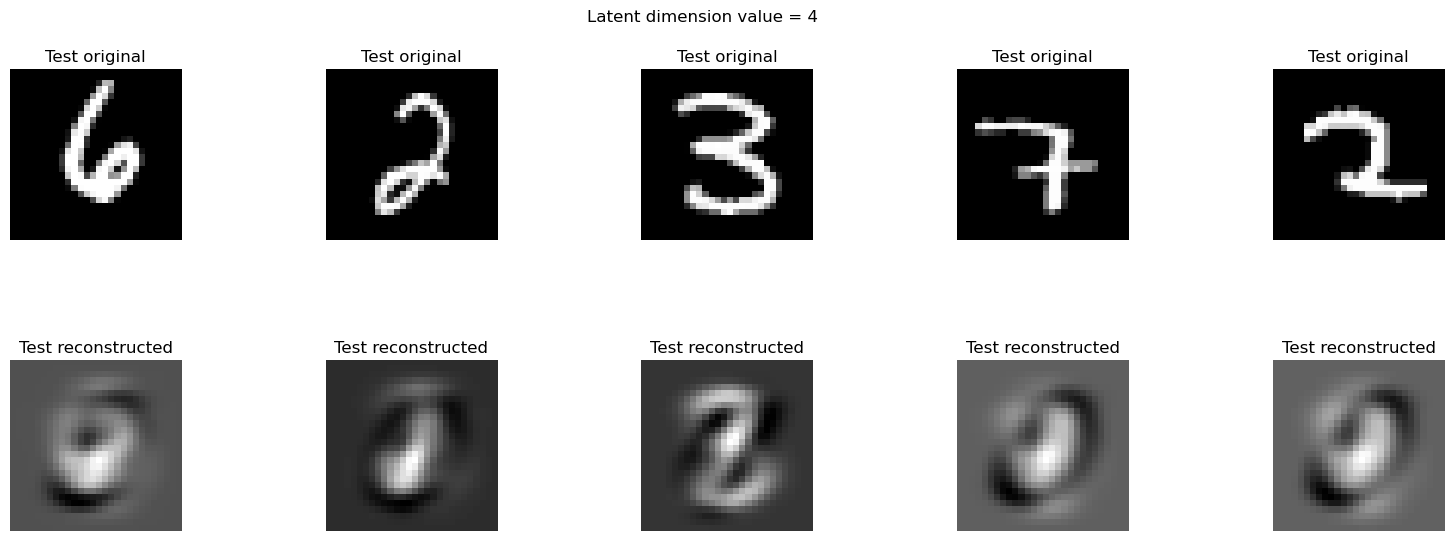

MSE val for latent dimension 8 is 0.07750603873774006


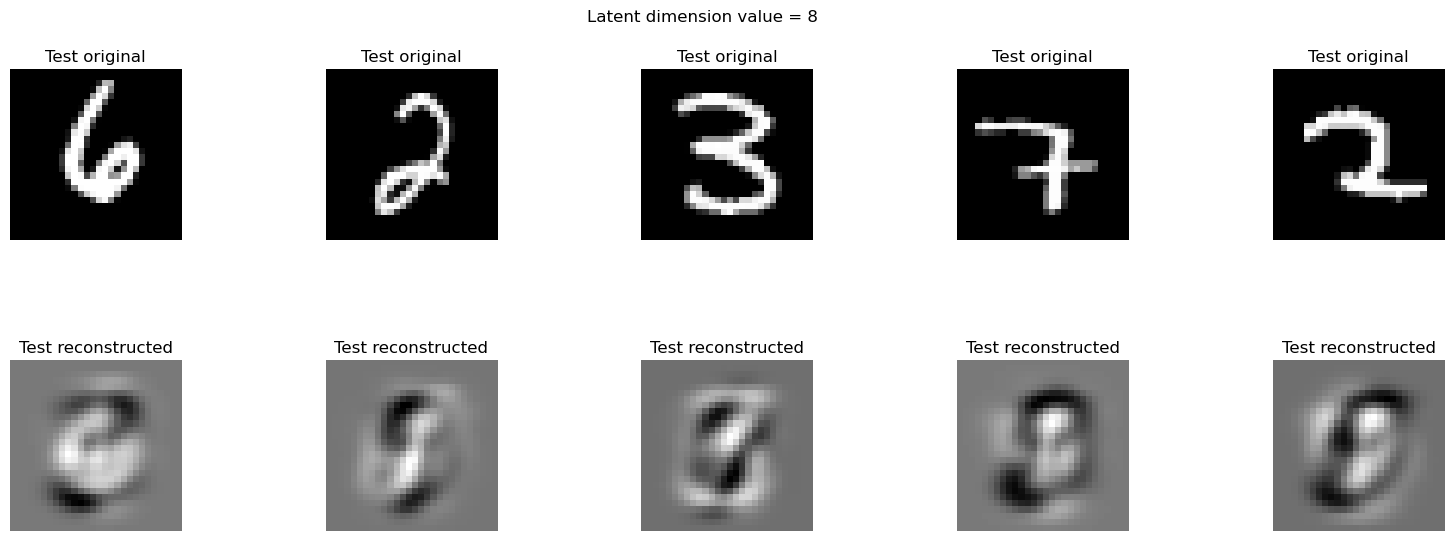

MSE val for latent dimension 16 is 0.07191685113844348


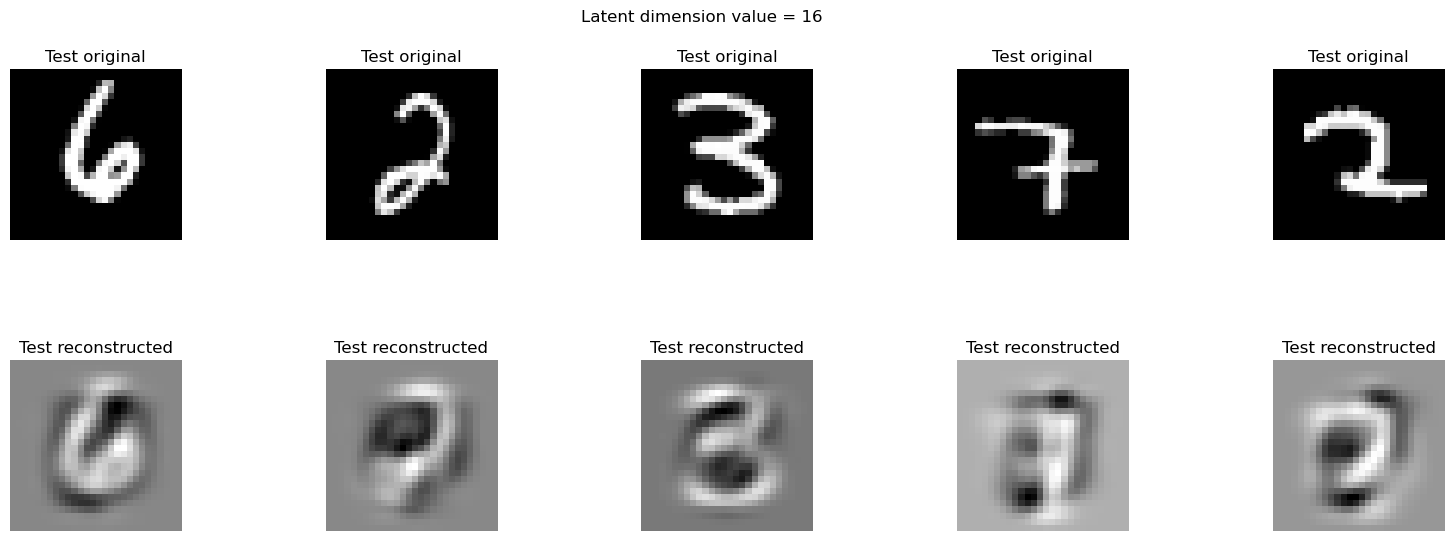

MSE val for latent dimension 32 is 0.06303978544636066


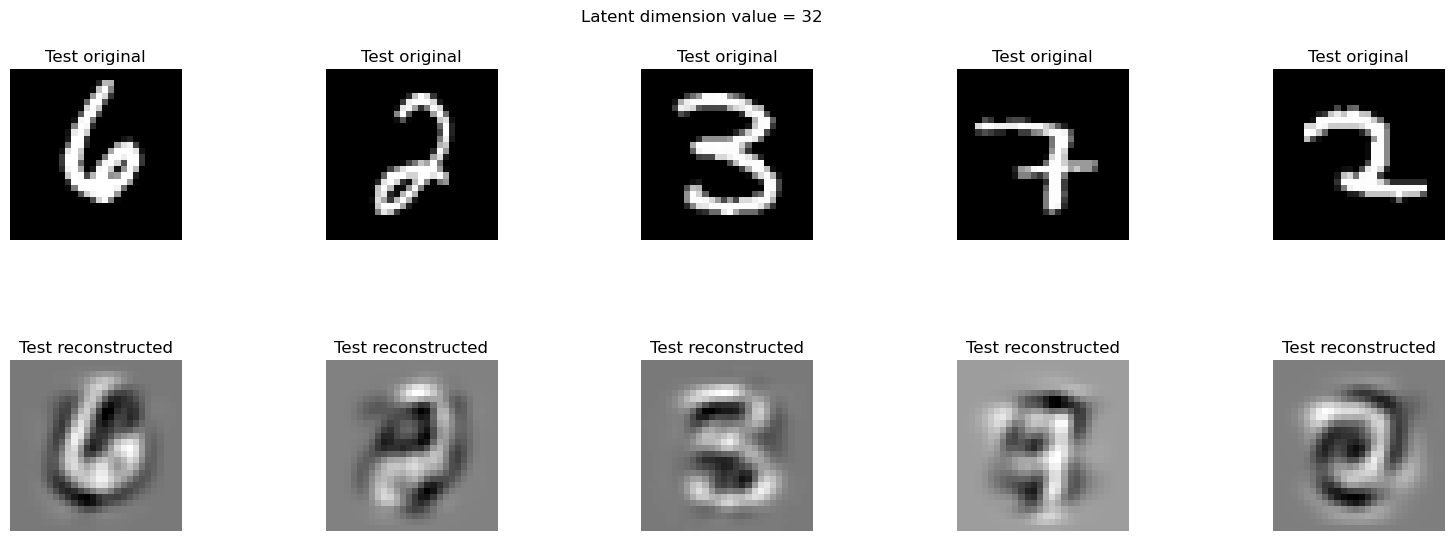

MSE val for latent dimension 64 is 0.05548393574838489


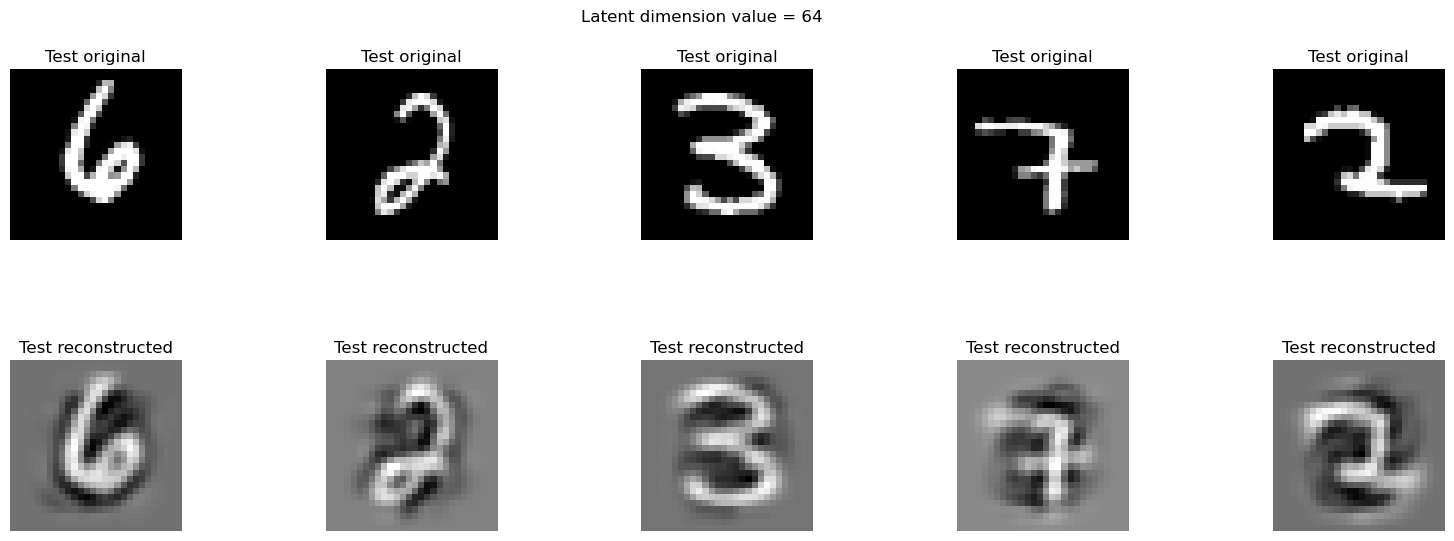

In [3]:
import matplotlib.pyplot as plt

latentDimensions = [2, 4, 8, 16, 32, 64]

def probabilisticPCA(centeredTrainImages, latentDimensionValue):
    '''numSamples = normalizedTrainImages.shape[0]
    trainMean = np.mean(normalizedTrainImages, axis = 0)
    covarianceMatrix = np.zeros((normalizedTrainImages.shape[1], normalizedTrainImages.shape[1]))
    imgCount = 0
    for image in normalizedTrainImages:
        imgCount = imgCount + 1
        print(imgCount)

        image = image.reshape(-1,1)
        covarianceMatrix += np.dot(image - trainMean, (image - trainMean.T))

    covarianceMatrix = covarianceMatrix / numSamples'''
    covarianceMatrix = (centeredTrainImages.T @ centeredTrainImages) / len(centeredTrainImages)

    #nan_indices = np.where(np.isnan(covarianceMatrix))
    #print("Indices with NaN in Covariance Matrix:", nan_indices)


    #print("Any NaN in Covariance Matrix:", np.any(np.isnan(covarianceMatrix)))       
    
    eigenValues, eigenVectors = np.linalg.eigh(covarianceMatrix)


    Um = eigenVectors[:, -latentDimensionValue:]    
    Lm = np.diag(eigenValues[-latentDimensionValue:])   #Diagonal matrix of eigenvalues

    I = np.eye(latentDimensionValue)
    sigmaSquare = abs(np.mean(np.sum(eigenVectors) - np.sum(Um)))
    R = I  # Since its arbitrary, we take R as an identity matrix
    
    weights = Um @ np.sqrt(abs(Lm - sigmaSquare * I)) @ R

    return weights

def imageReconstruction(testImages, weights, mean, sigma, latentDimensionValue):

    #Z, residuals, _, _ = np.linalg.lstsq(weights.T @ weights + 1e-5 * np.eye(weights.shape[1]), weights.T @ (normalizedImages - mean).T, rcond=None) 
    #print("Weights.T @ Weights:", weights.T @ weights)
    #print("Weights.T @ (normalizedImages - mean).T:", weights.T @ (normalizedImages - mean).T)

    #Z = np.linalg.solve((weights.T @ weights), (weights.T) @ (normalizedImages - mean).T) 
    #X = WZ + u
    #return (weights @ Z).T + mean

    M = weights.T @ weights + sigma**2 * np.eye(latentDimensionValue)

    z = (np.linalg.inv(M) @ weights.T @ (testImages - mean).T)

    K = (weights @ (np.linalg.inv(weights.T @ weights)) @ M @ z).T
    x_pred = K + mean.reshape(-1,1).T
    return x_pred

trainMean = np.mean(flattenedTrainImages, axis = 0)
#standardDev = np.std(flattenedTrainImages, axis = 0)
#N = flattenedTrainImages.shape[0]
#D = flattenedTrainImages.shape[1]
sigma = 1.0
testMean = np.mean(flattenedTestImages, axis = 0)

centeredTrainImages = flattenedTrainImages - trainMean
centeredTestImages = (flattenedTestImages - testMean)

ppca_mse_values_list = []

for latentDimensionValue in latentDimensions:

     
    weights = probabilisticPCA(centeredTrainImages, latentDimensionValue)
    reconstructedImages = imageReconstruction(centeredTestImages, weights, testMean, sigma, latentDimensionValue) 
    mseSum = 0

    plt.figure(figsize=(20,6))
    plt.suptitle(f"Latent dimension value = {latentDimensionValue}")
    #print(reconstructedImages.shape)
    
    for idx in range(len(centeredTestImages)):
        #print(normalizedTestImages[idx])
        #print(reconstructedImage)
        mseVal = np.mean((flattenedTestImages[idx] - reconstructedImages[idx])**2)
        mseSum += mseVal
        
    finalMse = (mseSum) / len(centeredTestImages)
    ppca_mse_values_list.append(finalMse)
    print("MSE val for latent dimension {} is {}".format(latentDimensionValue,finalMse))

    for i, idx in enumerate(selectedImages):
        plt.subplot(2, 5, i + 1)
        plt.imshow(flattenedTestImages[idx].reshape(28,28), cmap='gray')
        plt.title(f"Test original")
        plt.axis('off') #Removes x and y axis labels

        plt.subplot(2, 5, i + 6)
        plt.imshow(reconstructedImages[idx].reshape(28,28), cmap='gray')    #reshaping the 1d array back to 2d for accessing
        plt.title(f"Test reconstructed")
        plt.axis('off')

    plt.subplots_adjust(hspace=0.7, wspace=0.1)
    plt.show()
    
ppca_mse_values_array = np.array(ppca_mse_values_list)

## VARIATIONAL AUTOENCODER IMPLEMENTATION

Epoch 1/10
600/600 [==============================] - 10s 11ms/step - loss: 187.0851 - val_loss: 167.0046
Epoch 2/10
600/600 [==============================] - 6s 9ms/step - loss: 161.8802 - val_loss: 157.7550
Epoch 3/10
600/600 [==============================] - 5s 9ms/step - loss: 154.7763 - val_loss: 152.4528
Epoch 4/10
600/600 [==============================] - 5s 9ms/step - loss: 151.2897 - val_loss: 149.9466
Epoch 5/10
600/600 [==============================] - 6s 11ms/step - loss: 148.9705 - val_loss: 147.8568
Epoch 6/10
600/600 [==============================] - 6s 10ms/step - loss: 147.1688 - val_loss: 146.1867
Epoch 7/10
600/600 [==============================] - 8s 13ms/step - loss: 145.6698 - val_loss: 144.9635
Epoch 8/10
600/600 [==============================] - 8s 13ms/step - loss: 144.4552 - val_loss: 144.2065
Epoch 9/10
600/600 [==============================] - 7s 12ms/step - loss: 143.4877 - val_loss: 143.7095
Epoch 10/10
313/313 [==============================] - 1s

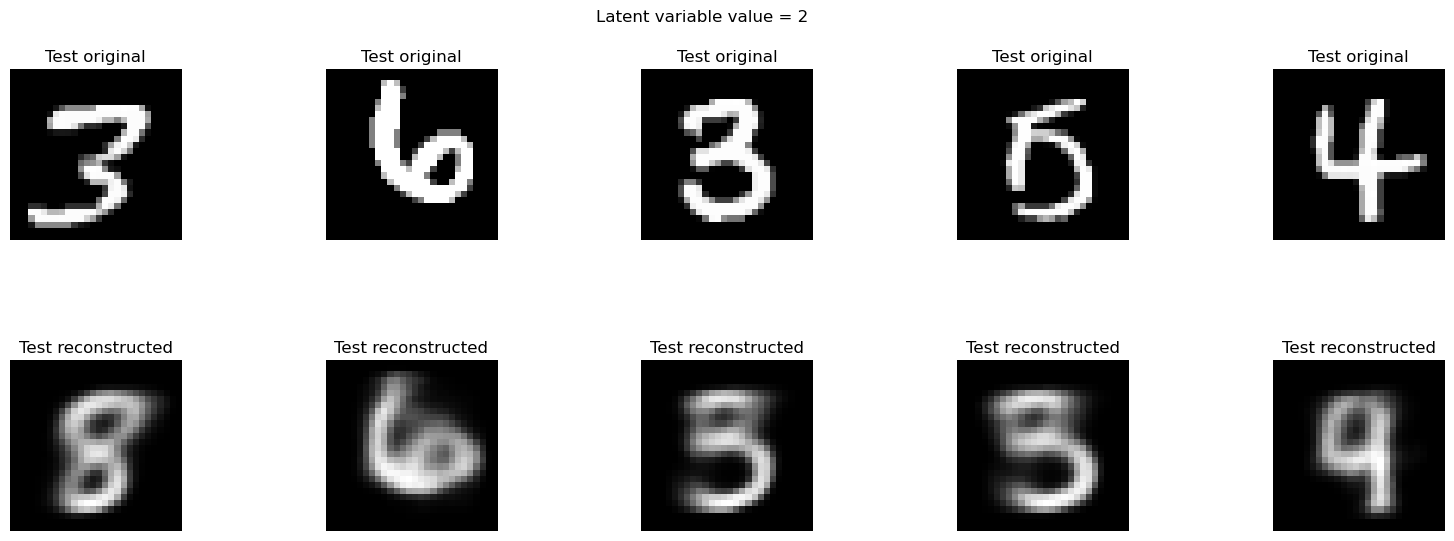

Epoch 1/10
600/600 [==============================] - 8s 11ms/step - loss: 171.5000 - val_loss: 143.2683
Epoch 2/10
600/600 [==============================] - 5s 9ms/step - loss: 138.5432 - val_loss: 134.0590
Epoch 3/10
600/600 [==============================] - 6s 9ms/step - loss: 132.2299 - val_loss: 129.8923
Epoch 4/10
600/600 [==============================] - 6s 9ms/step - loss: 128.9007 - val_loss: 126.9853
Epoch 5/10
600/600 [==============================] - 6s 10ms/step - loss: 126.6106 - val_loss: 125.4444
Epoch 6/10
600/600 [==============================] - 7s 12ms/step - loss: 124.9299 - val_loss: 124.0719
Epoch 7/10
600/600 [==============================] - 7s 11ms/step - loss: 123.6594 - val_loss: 123.4282
Epoch 8/10
600/600 [==============================] - 5s 9ms/step - loss: 122.5747 - val_loss: 122.2961
Epoch 9/10
600/600 [==============================] - 6s 10ms/step - loss: 121.7306 - val_loss: 121.9079
Epoch 10/10
313/313 [==============================] - 1s 2

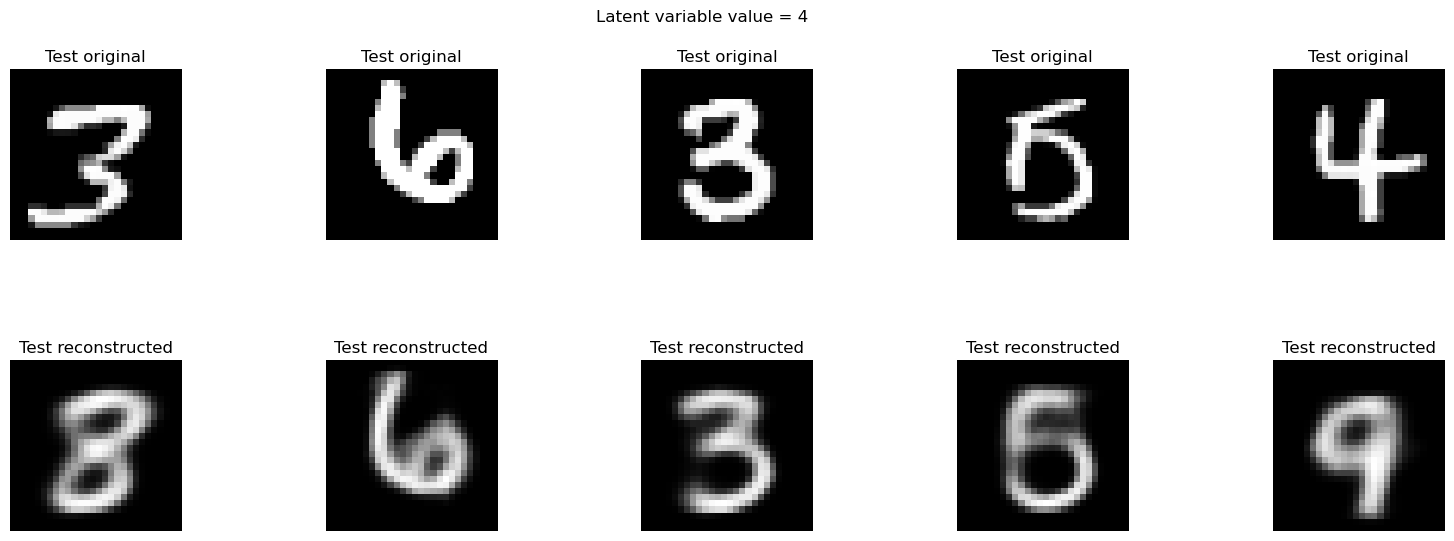

Epoch 1/10
600/600 [==============================] - 8s 11ms/step - loss: 164.1888 - val_loss: 133.2341
Epoch 2/10
600/600 [==============================] - 6s 11ms/step - loss: 125.4915 - val_loss: 118.8224
Epoch 3/10
600/600 [==============================] - 6s 10ms/step - loss: 116.8375 - val_loss: 113.3641
Epoch 4/10
600/600 [==============================] - 6s 9ms/step - loss: 112.6570 - val_loss: 109.8951
Epoch 5/10
600/600 [==============================] - 6s 9ms/step - loss: 109.9789 - val_loss: 108.6659
Epoch 6/10
600/600 [==============================] - 5s 9ms/step - loss: 108.0658 - val_loss: 106.1770
Epoch 7/10
600/600 [==============================] - 6s 9ms/step - loss: 106.5351 - val_loss: 105.7781
Epoch 8/10
600/600 [==============================] - 6s 9ms/step - loss: 105.3820 - val_loss: 104.3909
Epoch 9/10
600/600 [==============================] - 6s 9ms/step - loss: 104.3890 - val_loss: 103.3761
Epoch 10/10
313/313 [==============================] - 1s 2ms

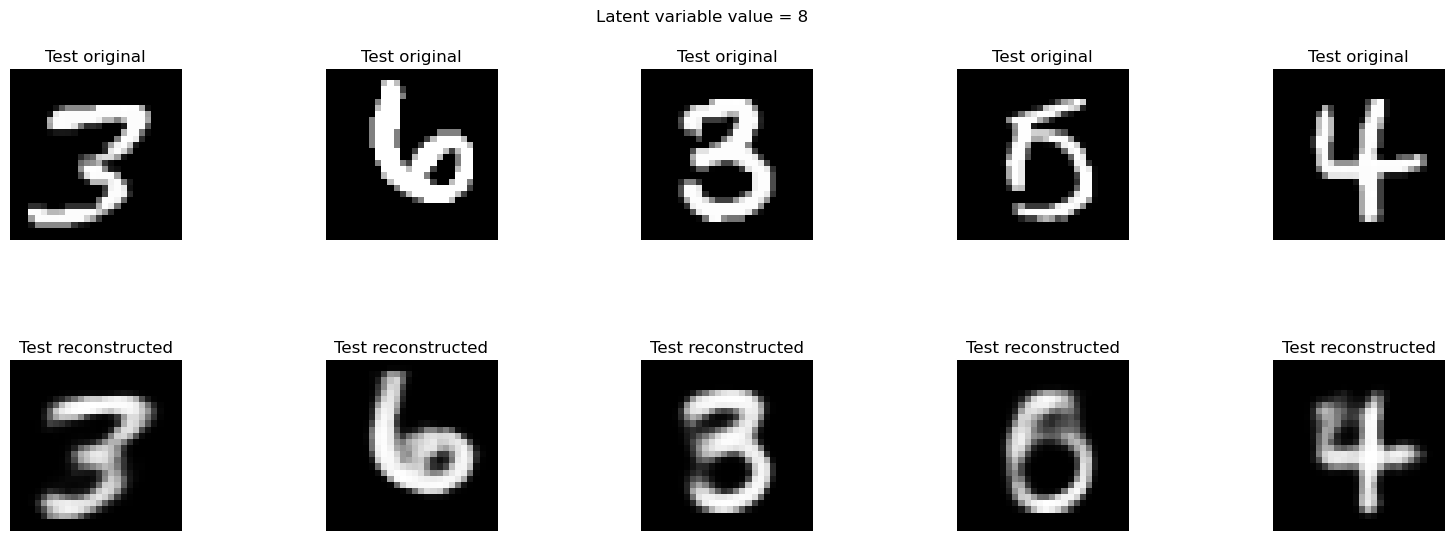

Epoch 1/10
600/600 [==============================] - 8s 10ms/step - loss: 162.5390 - val_loss: 130.1454
Epoch 2/10
600/600 [==============================] - 6s 9ms/step - loss: 122.6501 - val_loss: 114.1345
Epoch 3/10
600/600 [==============================] - 6s 9ms/step - loss: 112.0097 - val_loss: 107.7679
Epoch 4/10
600/600 [==============================] - 6s 10ms/step - loss: 106.5113 - val_loss: 104.6945
Epoch 5/10
600/600 [==============================] - 6s 10ms/step - loss: 103.1488 - val_loss: 100.1838
Epoch 6/10
600/600 [==============================] - 6s 9ms/step - loss: 100.9378 - val_loss: 99.0329
Epoch 7/10
600/600 [==============================] - 6s 9ms/step - loss: 99.4328 - val_loss: 98.7329
Epoch 8/10
600/600 [==============================] - 6s 10ms/step - loss: 98.1904 - val_loss: 97.0473
Epoch 9/10
600/600 [==============================] - 6s 11ms/step - loss: 97.2506 - val_loss: 96.1344
Epoch 10/10
313/313 [==============================] - 1s 2ms/step

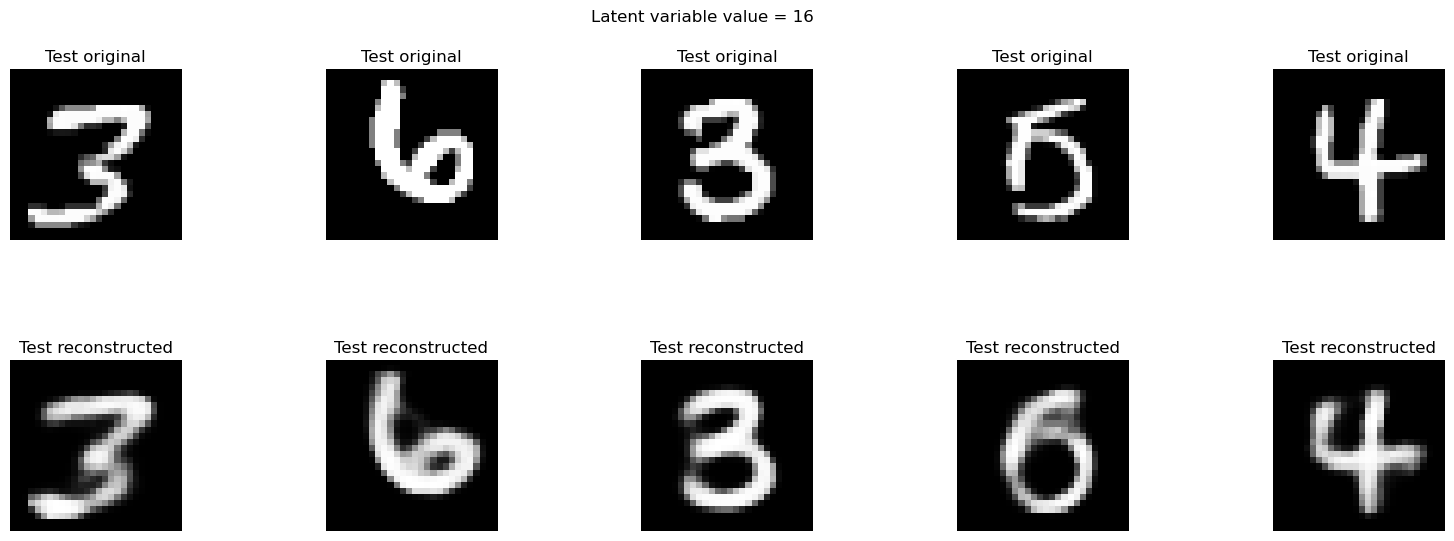

Epoch 1/10
600/600 [==============================] - 9s 12ms/step - loss: 165.3810 - val_loss: 134.0969
Epoch 2/10
600/600 [==============================] - 6s 10ms/step - loss: 126.4103 - val_loss: 117.0786
Epoch 3/10
600/600 [==============================] - 6s 10ms/step - loss: 114.1670 - val_loss: 108.2801
Epoch 4/10
600/600 [==============================] - 6s 11ms/step - loss: 107.7947 - val_loss: 103.8745
Epoch 5/10
600/600 [==============================] - 6s 10ms/step - loss: 103.7413 - val_loss: 102.5491
Epoch 6/10
600/600 [==============================] - 6s 9ms/step - loss: 101.1533 - val_loss: 99.3985
Epoch 7/10
600/600 [==============================] - 6s 9ms/step - loss: 99.3379 - val_loss: 97.4946
Epoch 8/10
600/600 [==============================] - 6s 9ms/step - loss: 97.9865 - val_loss: 96.0911
Epoch 9/10
600/600 [==============================] - 6s 9ms/step - loss: 96.9574 - val_loss: 96.0113
Epoch 10/10
313/313 [==============================] - 1s 2ms/step

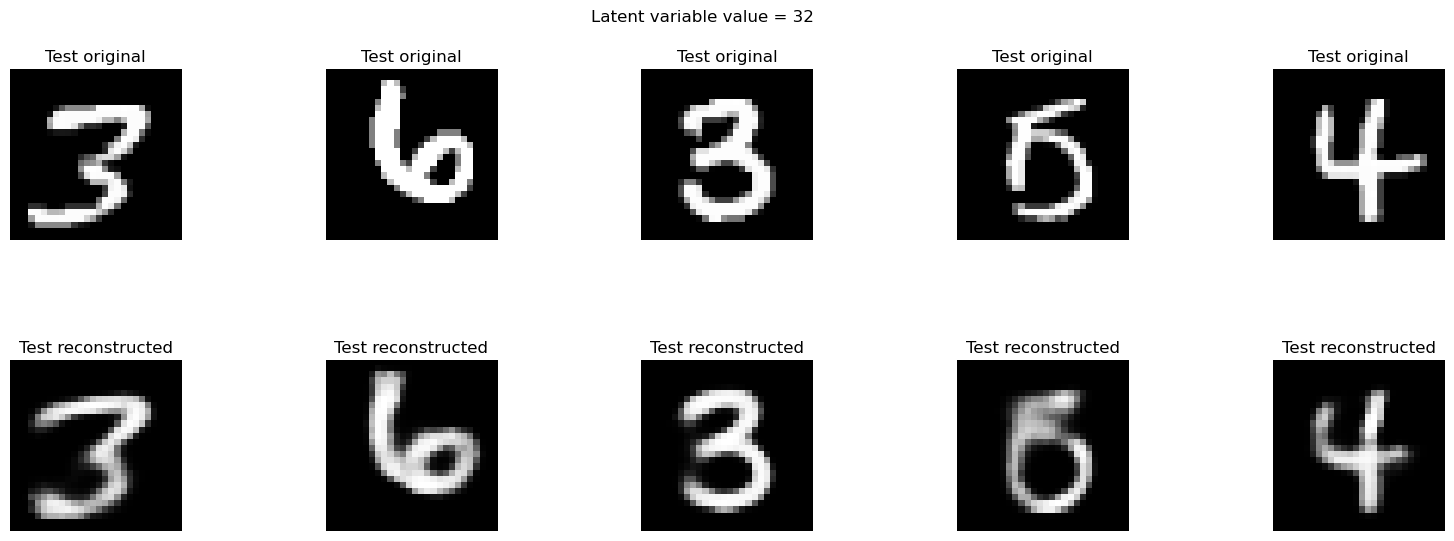

Epoch 1/10
600/600 [==============================] - 7s 10ms/step - loss: 165.8522 - val_loss: 137.7139
Epoch 2/10
600/600 [==============================] - 5s 9ms/step - loss: 130.0088 - val_loss: 120.9727
Epoch 3/10
600/600 [==============================] - 5s 9ms/step - loss: 117.2383 - val_loss: 112.4920
Epoch 4/10
600/600 [==============================] - 6s 10ms/step - loss: 110.1158 - val_loss: 106.2705
Epoch 5/10
600/600 [==============================] - 6s 10ms/step - loss: 105.5444 - val_loss: 103.0968
Epoch 6/10
600/600 [==============================] - 7s 12ms/step - loss: 102.5462 - val_loss: 102.0515
Epoch 7/10
600/600 [==============================] - 6s 9ms/step - loss: 100.3903 - val_loss: 98.5720
Epoch 8/10
600/600 [==============================] - 6s 10ms/step - loss: 98.7752 - val_loss: 97.3934
Epoch 9/10
600/600 [==============================] - 6s 10ms/step - loss: 97.6376 - val_loss: 96.4849
Epoch 10/10
313/313 [==============================] - 1s 2ms/s

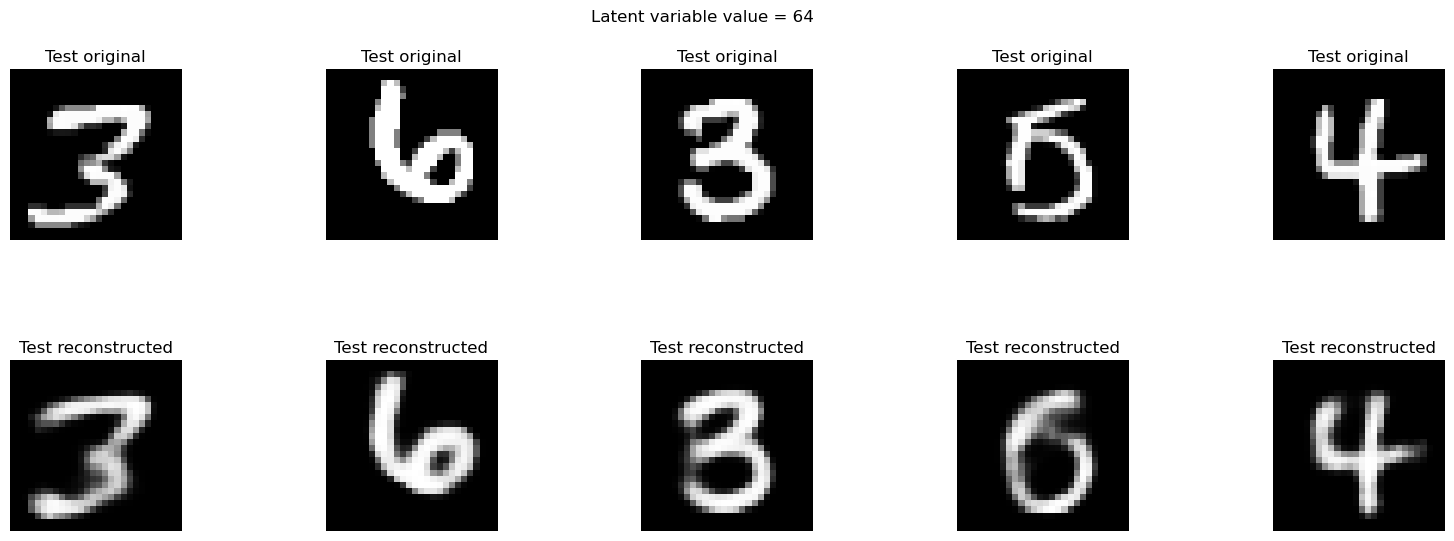

In [4]:
import numpy as np
import sklearn
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from keras.datasets import mnist
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from scipy.stats import norm

latentDimensions = [2, 4, 8, 16, 32, 64]
# latentDimensions = [2]
randomImages = random.sample(range(len(testImages)), 5)

batch_size, epoch = 100, 10
n_hidden = 256

def normalization(flattenedTrainImages):
    mean = np.mean(flattenedTrainImages, axis = 0)
    standardDev = np.std(flattenedTrainImages, axis = 0)

    #Handle 0 variance here, else NaN values are produced
    zeroVarianceIndices = np.where(standardDev == 0)[0]
    standardDev[zeroVarianceIndices] = 1e-5

    normalizedImages = (flattenedTrainImages - mean) / standardDev
    return normalizedImages, mean, standardDev

def variationalAutoEncoder(flattenedTrainImages, flattenedTestImages, latentDimensionValue):
    
    x = Input(shape=(flattenedTrainImages.shape[1:]))
    h1 = Dense(256, activation='relu')(x)
    h1 = Dense(128, activation='relu')(h1)

    mu = Dense(latentDimensionValue)(h1)
    log_var = Dense(latentDimensionValue)(h1)

    def sampling(args):
        mu, log_var = args
        eps = K.random_normal(shape=(batch_size, latentDimensionValue), mean=0., stddev=1.0)
        return mu + K.exp(log_var) * eps

    z = Lambda(sampling, output_shape=(latentDimensionValue,))([mu, log_var])

    z1 = Dense(128, activation='relu')
    z2 = Dense(256, activation='relu')
    y_decoder = Dense(flattenedTrainImages.shape[1], activation='sigmoid')

    h2 = z1(z)
    h2 = z2(h2)
    y = y_decoder(h2)

    kl_loss = 0.5 * K.sum(K.square(mu) + K.exp(log_var) - log_var - 1, axis = -1)
    reconstruction_loss = K.sum(K.binary_crossentropy(x, y), axis=-1)

    vae_loss = reconstruction_loss + kl_loss

    vae = Model(x, y)
    vae.add_loss(vae_loss)
    vae.compile(optimizer='rmsprop')

    vae.fit(flattenedTrainImages,epochs=epoch,batch_size=batch_size,validation_data=(flattenedTestImages, None), verbose=1)

    encoder = Model(x, mu)
    z_latent = encoder.predict(flattenedTestImages, batch_size=batch_size)

    decoder_input = Input(shape=(latentDimensionValue,))
    h3 = z1(decoder_input)
    h3 = z2(h3)
    generatedImage = y_decoder(h3)
    generator = Model(decoder_input, generatedImage)

    reconstructed = generator.predict(z_latent)
    
    return reconstructed


normalizedTrainImages, mean, standardDev = normalization(flattenedTrainImages)
VAE_mse_values_list = []
for latentDimensionValue in latentDimensions:

    normalizedTestImages = (flattenedTestImages - mean) / standardDev
    reconstructedImages = variationalAutoEncoder(flattenedTrainImages, flattenedTestImages, latentDimensionValue)
    mseVal = np.mean(np.square(flattenedTestImages - reconstructedImages))
    VAE_mse_values_list.append(mseVal)
    print("MSE for latent dimension {} is: {}".format(latentDimensionValue,mseVal))

    plt.figure(figsize=(20,6))
    plt.suptitle(f"Latent variable value = {latentDimensionValue}")

    for i, idx in enumerate(randomImages):
        plt.subplot(2, 5, i + 1)
        plt.imshow(testImages[idx], cmap='gray')
        plt.title(f"Test original")
        plt.axis('off') #Removes x and y axis labels

        plt.subplot(2, 5, i + 6)
        # reconstructed_image_np = reconstructedImages[idx].numpy()
        plt.imshow(reconstructedImages[idx].reshape(28,28), cmap='gray')
        plt.title(f"Test reconstructed")
        plt.axis('off')

    plt.subplots_adjust(hspace=0.7, wspace=0.1)
    plt.show()
VAE_mse_values_array = np.array(VAE_mse_values_list)

## GRAPH PLOTTING

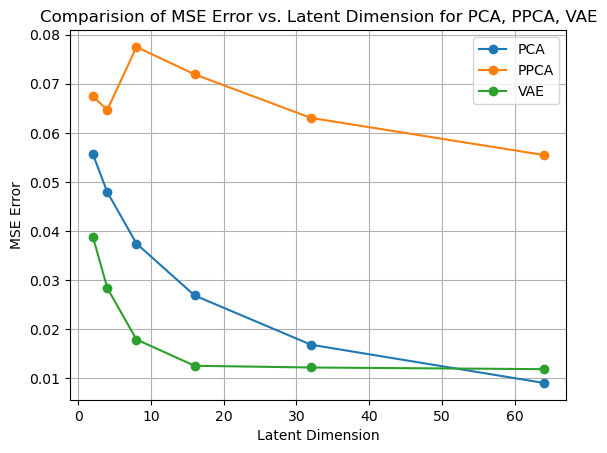

In [5]:
import numpy as np
import matplotlib.pyplot as plt

latent_dimensions = [2, 4, 8, 16, 32, 64]

# Plotting
plt.plot(latent_dimensions, mse_values_array, marker='o', label = 'PCA')
plt.plot(latent_dimensions, ppca_mse_values_array, marker='o', label = 'PPCA')
plt.plot(latent_dimensions, VAE_mse_values_array, marker='o', label = 'VAE')
plt.legend()
plt.xlabel('Latent Dimension')
plt.ylabel('MSE Error')
plt.title('Comparision of MSE Error vs. Latent Dimension for PCA, PPCA, VAE')
plt.grid(True)
plt.show()